# Bayesian Sample Visualizer (BSAVI)
This is the notebook where I'm currently developing the visualizer. I'm using Holoviews and Panel to construct the dashboard and implement the interactivity.

In [ ]:
import bsavi as bsv

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
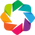

In [11]:
import numpy as np
import pandas as pd
import os
from tqdm import trange, tqdm
from glob import iglob
from typing import List, Callable, Union
from itertools import combinations

# from classy import Class
# from multiprocessing import Pool

import holoviews as hv
from holoviews import dim, opts, streams
from holoviews.selection import link_selections
# import hvplot.pandas

from bokeh.models import HoverTool
import matplotlib.pyplot as plt
import panel as pn

# pn.extension(loading_spinner='dots', loading_color='#00aa41', sizing_mode="stretch_width")

# hv.Store.set_current_backend('bokeh')
hv.extension('bokeh')
pn.extension('mathjax')


## Function & Class Definitions

### Loaders

In [3]:
# methods to process data products from the CLASS cosmology code.

# read in the .paramnames file and return a dict of parameters and their LaTeX formatting
def load_params(filename):
    params_list = []
    with open(filename, 'r') as f:
        for line in f:
            param_and_latex = line.split('\t')
            param_and_latex = [item.strip() for item in param_and_latex]
            params_list.append(param_and_latex)
    return dict(params_list)

# create a DataFrame from the chain files and use a list of parameters as the column names
def load_chains(path, params, params_only=True):
    if isinstance(path, list):
        array_list = [np.loadtxt(filename) for filename in tqdm(path)]
    else: 
        file_list = sorted(iglob(path))
        array_list = [np.loadtxt(filename) for filename in tqdm(file_list)]
    chains = np.vstack(array_list)
    columns = ['weight', '-LogLkl'] + params
    if params_only:
        df = pd.DataFrame(chains[:, 2:], columns=params)
    else:
        df = pd.DataFrame(chains, columns=columns)
    return df

### Cosmo

In [13]:
# run class on the user's selection with default settings
def run_class(index, sample):
    selection = sample.iloc[[index]].to_dict('index')

    cosmo = Class()
    cosmo.set(selection[index])
    cosmo.set({'output':'mPk, tCl, pCl, lCl','P_k_max_1/Mpc':3.0, 'lensing':'yes'})
    cosmo.compute()

    # set variables for matter power spectrum and lensed CMB angular power spectra
    kk = np.logspace(-4,np.log10(3),1000)
    Pk = []
    h = cosmo.h()
    for k in kk:
        Pk.append(cosmo.pk(k*h,0.)*h**3)
    Pk = np.array(Pk)
    l = np.array(range(2,2501))
    factor = l*(l+1)/(2*np.pi)
    lensed_cl = cosmo.lensed_cl(2500)
    
    results = [
        {'k': kk, 'Pk': Pk},
        {'l': l, 'Cl_tt': factor*lensed_cl['tt'][2:]},
        {'l': l, 'Cl_ee': factor*lensed_cl['ee'][2:]}, 
    ]
    # cleanups requried for backwards compat w CLASS 2.x
    cosmo.struct_cleanup()
    cosmo.empty()
    return results

# calculate percentage difference between model of interest and LambdaCDM model
def compute_residuals(index, sample, sample_CDM):
    if __name__ == '__main__':
        with Pool() as p:
            [mycosmo, LambdaCDM] = p.starmap(run_class, [(index, sample), (index, sample_CDM)])
    else:
        mycosmo = run_class(index, sample)
        LambdaCDM = run_class(index, sample_CDM)

    myPk, myCl_tt, myCl_ee = mycosmo
    LCDM_Pk, LCDM_Cl_tt, LCDM_Cl_ee = LambdaCDM
    pk_residuals = (myPk['Pk'] - LCDM_Pk['Pk'])/LCDM_Pk['Pk']*100
    cl_tt_residuals = (myCl_tt['Cl_tt'] - LCDM_Cl_tt['Cl_tt'])/LCDM_Cl_tt['Cl_tt']*100
    cl_ee_residuals = (myCl_ee['Cl_ee'] - LCDM_Cl_ee['Cl_ee'])/LCDM_Cl_ee['Cl_ee']*100
    
    residuals = [
        {'k': myPk['k'], 'pk_residuals': pk_residuals}, 
        {'l': myCl_tt['l'], 'cl_tt_residuals': cl_tt_residuals}, 
        {'l': myCl_ee['l'], 'cl_ee_residuals': cl_ee_residuals},
    ]
    return residuals

### Utils

In [4]:
# unpacks the nested data. handles the two supported datatypes
def _unpacker(dataset, index):
    if isinstance(dataset, dict):
        unpacked_data = {key: dataset[key][index] for key in dataset.keys()}
    if isinstance(dataset, pd.core.frame.DataFrame):
        columns = dataset.columns
        dataseries = dataset.iloc[index]
        unpacked_data = pd.DataFrame({columns[item]: dataseries[columns[item]] for item in range(len(columns))})
    return unpacked_data


#  given a param name, find corresponding latex-formatted param name
def _lookup_latex_label(param, latex_dict):
    # handle default case of no latex paramname dictionary
    if latex_dict is None:
        latex_dict = dict()
    try:
        latex_param = latex_dict[param]
        label = r'$${}$$'.format(latex_param)
        return label
    except KeyError:
        label = param
        return label

### Observable

In [5]:
class Observable:
    """
    Observable class for BSAVI.
    
    Parameters
    ----------
    name: string or list of strings
        specifies the display name of the observable for things like plot titles

    parameters: dict-like or list of dict-likes
        the data to associated with that observable. can be python dict (or pandas DataFrame)
        whose keys (or column names) will be used for things like plot axis labels. 

    myfunc: callable
        a user-provided function that returns parameters. can return more than one
        set of parameters.

    myfunc_args: tuple
        arguments for user-provided function

    plot_type: string
        specifies how the data should be visualized. currently can pick either 'Curve'
        or 'Scatter'

    plot_opts: holoviews Options object
        customization options for the observable plot. see Holoviews documentation

    latex_labels: dict or list of dicts
        key: value -> parameter label: latex version. parameter label must match the
        corresponding one in the parameters dict
    """
    
    def __init__(
        self, 
        name: Union[str, List[str]], 
        parameters: Union[dict, List[dict]] = None, 
        myfunc: Callable = None,
        myfunc_args: tuple = None, 
        plot_type: Union[str, List[str]] = None,
        plot_opts: Union[opts, List[opts]] = None,
        latex_labels: dict = None
    ):
        if isinstance(name, str):
            self.name = [name]
        else:
            self.name = name
        if isinstance(parameters, dict):
            self.parameters = [parameters]
        elif isinstance(parameters, pd.core.frame.DataFrame):
            prms = []
            for column in parameters.columns:
                dset = pd.DataFrame(list(parameters.loc[:, column]))
                prms.append(dset)
            self.parameters = prms
        else:
            self.parameters = parameters
        self.myfunc = myfunc
        self.myfunc_args = myfunc_args
        if isinstance(plot_type, str):
            self.plot_type = [plot_type]
        else:
            self.plot_type = plot_type
        if isinstance(plot_opts, hv.core.options.Options):
            self.plot_opts = [plot_opts]
        else:
            self.plot_opts = plot_opts
        self.latex_labels = latex_labels
        self.number = len(self.name)
    
    def properties(self):
        if len(self.name) > 1:
            print("BSAVI Grouped Observables")
            for i in range(len(self.name)):
                print(f"\t- Observable {i+1}: {self.name[i]}")
        else:
            print("BSAVI Observable")
            print(f"Name: {self.name[0]}")
        
    def generate_plot(self, index: int):
        self.plots_list = []
        if self.myfunc and self.myfunc_args is not None:
            computed_data = self.myfunc(index, *self.myfunc_args)
            self.number = len(computed_data)
        for i in range(0, self.number):
            if len(self.plot_type) == 1:
                hv_element = getattr(hv, self.plot_type[0])
            else:
                hv_element = getattr(hv, self.plot_type[i])
            if self.parameters is not None:
                dataset = self.parameters[i]
                unpacked_data = _unpacker(dataset, index)
                kdim, vdim = unpacked_data.keys()
                plot = hv_element(unpacked_data, kdim, vdim, group=self.name[i], label=str(index)) #TODO
                # plot = hv_element(unpacked_data, kdim, vdim, label=self.name[i])
            elif computed_data:
                dataset = computed_data[i]
                kdim, vdim = dataset.keys()
                plot = hv_element(dataset, kdim, vdim, group=self.name[i], label=str(index)) #TODO
                # plot = hv_element(dataset, kdim, vdim, label=self.name[i])
            # set defaults
            plot.opts(
                title=f'{self.name[i]}',
                height=400,
                width=500,
                padding=0.1,
                fontscale=1.1,
                xlabel=_lookup_latex_label(kdim, self.latex_labels), 
                ylabel=_lookup_latex_label(vdim, self.latex_labels),
                framewise=True
            )
            # add user defined customizations
            if self.plot_opts is not None:
                if len(self.plot_opts) == 1:
                    plot.opts(self.plot_opts)
                else:
                    plot.opts(self.plot_opts[i])
            
            self.plots_list.append(plot)
        return self.plots_list
        
    def draw_plot(self, index):
        layout = hv.Layout(self.generate_plot(index))
        return layout.opts(shared_axes=False)

### Viz

In [6]:
# generate the visualization
def viz(
    data, 
    observables: list = None, 
    show_observables: bool = False, 
    latex_dict: dict = None
):
    # setting Panel widgets for user interaction
    variables = data.columns.values.tolist()
    var1 = pn.widgets.Select(
        value=variables[0], 
        name='Horizontal Axis', 
        options=variables,
        width=150
    )
    var2 = pn.widgets.Select(
        value=variables[1], 
        name='Vertical Axis', 
        options=variables,
        width=150
    )
    cmap_var = pn.widgets.Select(
        value=variables[2], 
        name='Colormap', 
        options=variables,
        width=150
    )
    cmap_option = pn.widgets.Checkbox(
        value=True, 
        name='Show Colormap', 
        align='end',
        width=150
    )

    # function for generating the scatter plot, given 2 dimensions as x and y axes, and an additional dimension to colormap
    # to the points on the plot. Also has an option to show or hide the colormap
    def plot_data(kdim1, kdim2, colordim, showcmap):
        if showcmap == True:
            cmapping = opts.Points(
                color=dim(colordim),
                colorbar=True,
                cmap='Spectral_r')
        else:
            cmapping = opts.Points(color='grey', colorbar=True)
        hover = HoverTool(tooltips=None)
        xlabel = _lookup_latex_label(kdim1, latex_dict)
        ylabel = _lookup_latex_label(kdim2, latex_dict)
        popts = opts.Points(
            title='Sample Data',
            bgcolor='#f5f5f5',
            fontscale=1.1,
            xlabel=xlabel,
            ylabel=ylabel,
            toolbar='above',
            line_color='black',
            #alpha=0.75, selection_alpha=1, nonselection_alpha=0.1,
            tools=[hover, 'box_select','lasso_select','tap'],
            size=7)
        points = hv.Points(data, kdims=[kdim1, kdim2]).opts(popts, cmapping)
        return points
    
    # bind the widget values to the plotting function so it gets called every time the user interacts with the widget
    # call the bound plotting function inside a holoview DynamicMap object for interaction
    interactive_points = pn.bind(plot_data, kdim1=var1, kdim2=var2, colordim=cmap_var, showcmap=cmap_option)
    points_dmap = hv.DynamicMap(interactive_points, kdims=[]).opts(width=500, height=400, framewise=True)
    
    # define a stream to get a list of all the points the user has selected on the plot
    selection = streams.Selection1D(source=points_dmap)
    
    # formatting the table using plot hooks
    def hook(plot, element):
        plot.handles['table'].autosize_mode = "none"
        for column in plot.handles['table'].columns:
            column.width = 100
    
    # function to generate a table of all the selected points
    def make_table(kdim1, kdim2, colordim):
        table_options = opts.Table(
            height=300, 
            width=600, 
            hooks=[hook], 
            bgcolor='#f5f5f5'
        )
        data_with_index = data.reset_index()
        table = hv.DynamicMap(
            lambda index: hv.Table(data_with_index.iloc[index], kdims=['index', kdim1, kdim2, colordim]), 
            streams=[selection]
        )
        return table.opts(table_options).relabel('Selected Points')
    
    
    # generate the table
    selected_table = pn.bind(
        make_table, 
        kdim1=var1, 
        kdim2=var2, 
        colordim=cmap_var)
    
    #table_stream = streams.Selection1D(source=selected_table)
    
    # handles the null selection case and multiple selections
    plots = {}
    # get total number of plots to draw from list of observables
    plotting_info = {}
    if observables is None:
        observables = []
    else:
        show_observables = True
    for each in observables:
        for i in range(len(each.name)):
            if each.plot_opts is None:
                specific_opts = None
            elif len(each.plot_opts) == 1:
                specific_opts = each.plot_opts[0]
            elif each.plot_opts[i] is not None:
                specific_opts = each.plot_opts[i]
            
            if len(each.plot_type) == 1:
                plotting_info[each.name[i]] = {'type': each.plot_type[0], 'opts': specific_opts}
            else:
                plotting_info[each.name[i]] = {'type': each.plot_type[i], 'opts': specific_opts}

    def plot_observables(index):
        if not index:
            plots_list = []
            for name in plotting_info:
                hv_type = getattr(hv, plotting_info[name]['type'])
                empty_plot = hv_type(np.random.rand(0, 2), group=f'{name}', label='None').opts(
                    title=f'{name} - No Selection', 
                    height=400, 
                    width=500, 
                    fontscale=1.1, 
                    framewise=True)
                if plotting_info[name]['opts'] is not None:
                    empty_plot.opts(plotting_info[name]['opts'])
                plots_list.append([empty_plot])
        else:
            new_index = [x for x in index if x not in list(plots.keys())]
            for element in new_index:
                new_plots = []
                for each in observables:
                    new_plots.extend(each.generate_plot(element))
                plots[element] = {plot.group: plot for plot in new_plots} #TODO
                # plots[element] = {plot.label: plot for plot in new_plots}
            
            plots_list = []
            for index_item in index:
                plot_types = list(plots[index_item].keys())

            for plot_item in plot_types:
                same_type = [plots[key][plot_item] for key in index]
                plots_list.append(same_type)
            
        layout = hv.Layout()
        for list_of_plots in plots_list:
            overlay = hv.Overlay(list_of_plots).opts(show_legend=True, legend_position='right')
            layout = layout + overlay
        layout.opts(shared_axes=False, toolbar='left').cols(2)
        return layout
    
    # put it all together using Panel
    input_panel = pn.Row(
        pn.Column(var1, var2, cmap_var, cmap_option), 
        points_dmap
    )
    dashboard = pn.Column(input_panel, selected_table)
    
    if show_observables == True:
        observables_dmap = hv.DynamicMap(plot_observables, streams=[selection]).opts(framewise=True)
        observables_pane = pn.panel(observables_dmap)
        dashboard = pn.Row(dashboard, observables_pane)
    
    return dashboard

## Testing

### Live CLASS Compute

In [14]:
# Read in data
params_with_latex = load_params('../data/chains_planckbossdes_1MeV/2022-11-16_3200000_.paramnames')
param_names = list(params_with_latex.keys())
chains = load_chains('../data/chains_planckbossdes_1MeV/*.txt', param_names, params_only=False)
# downsample to avoid overplotting
chains = chains.sample(n=500, random_state=1).reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.13it/s]


In [28]:
chains

,weight,-LogLkl,omega_b,omega_cdm,100theta_s,ln10^{10}A_s,n_s,tau_reio,sigma_dmeff,A_cib_217,...,b^{(3)}_{G_2},b^{(4)}_1,b^{(4)}_2,b^{(4)}_{G_2},z_reio,Omega_Lambda,YHe,H0,A_s,sigma8
0,10.0,1938.83,2.248318,0.119332,1.042182,3.048260,0.971407,0.056778,11.290030,57.64860,...,-0.425008,1.945656,0.433658,-0.077483,7.905899,0.690268,0.247888,67.82770,2.107865,0.781393
1,1.0,1941.59,2.254123,0.117495,1.042933,3.053014,0.979647,0.058020,14.344720,50.18726,...,-0.107092,1.917278,0.120145,0.177061,7.987320,0.702645,0.247913,68.79148,2.117909,0.773740
2,1.0,1943.55,2.253810,0.119314,1.042514,3.039749,0.979631,0.050911,17.943620,42.88607,...,-0.249574,1.959406,-0.406269,-0.420163,7.295944,0.691705,0.247911,67.99455,2.090001,0.769145
3,1.0,1949.12,2.244370,0.120806,1.042372,3.036513,0.971659,0.047792,9.911594,63.48922,...,-0.419936,1.973465,-0.825603,-0.720338,7.009567,0.682566,0.247871,67.33631,2.083248,0.785049
4,2.0,1950.49,2.246100,0.119666,1.042378,3.050763,0.969741,0.052976,7.156315,53.47621,...,-0.318238,1.985193,1.316616,-0.008460,7.531082,0.688922,0.247878,67.75491,2.113147,0.792608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,8.0,1940.88,2.279238,0.119696,1.043614,3.048746,0.989507,0.054669,24.987380,45.20365,...,-0.367670,1.973764,-0.117055,-0.364188,7.634262,0.694513,0.248018,68.45853,2.108888,0.767634
496,2.0,1939.81,2.239859,0.119556,1.042558,3.045309,0.965476,0.052839,7.059579,53.32921,...,-0.739254,1.957262,-0.097419,0.148970,7.528976,0.689695,0.247852,67.79826,2.101653,0.789536
497,4.0,1943.29,2.252415,0.119442,1.042354,3.045034,0.970495,0.051119,6.441022,44.52591,...,-0.398638,1.992126,0.929144,0.231860,7.322617,0.690448,0.247905,67.88335,2.101075,0.791309
498,4.0,1939.04,2.280373,0.118121,1.041872,3.042649,0.971225,0.055011,3.928614,47.96937,...,-0.712613,1.943005,-0.432138,-0.468489,7.637772,0.697725,0.248023,68.44433,2.096069,0.791463


In [16]:
# prepare data for CLASS computation

# remove nuisance parameters
classy_input = chains.loc[:, ('omega_b', 'omega_cdm', 'ln10^{10}A_s', 'n_s', 'tau_reio', 'sigma_dmeff', 'Omega_Lambda', 'YHe', 'H0')]
classy_input['omega_b'] = classy_input['omega_b'] * 1e-2
classy_input['sigma_dmeff'] = classy_input['sigma_dmeff'] * 1e-25
classy_input = classy_input.rename(columns={'H0':'h'})
classy_input['h'] = classy_input['h'] * 1e-2
classy_input['f_dmeff'] = 0.1
classy_input['npow_dmeff'] = 0.0
classy_input['Vrel_dmeff'] = 0.0
classy_input['dmeff_target'] = 'baryons'
classy_input['m_dmeff'] = 1e-3

# format for CDM version
classy_CDM = classy_input.drop(columns=['sigma_dmeff', 'npow_dmeff', 'Vrel_dmeff', 'dmeff_target', 'm_dmeff'])

In [19]:
cosmo_copts = opts.Curve(
    logx=True, 
    color=hv.Cycle('Spectral'), 
    bgcolor='#222222', 
    framewise=True
)
resids_latex = {
    'k': 'k~[h/\mathrm{Mpc}]',
    'pk_residuals': '(P(k)-P_{CDM}(k))/P_{CDM}(k)*100~[\%]',
    'l': '\ell',
    'cl_tt_residuals': '(C_{\ell}^{TT}-C_{\ell, CDM}^{TT})/C_{\ell, CDM}^{TT}*100~[\%]',
    'cl_ee_residuals': '(C_{\ell}^{EE}-C_{\ell, CDM}^{EE})/C_{\ell, CDM}^{EE}*100~[\%]',
}
residuals = Observable(
    name=['P(k) Residuals', 'Cl_TT Residuals', 'Cl_EE Residuals'], 
    myfunc=compute_residuals,
    myfunc_args=(classy_input, classy_CDM), 
    plot_type='Curve',
    plot_opts=cosmo_copts,
    latex_labels=resids_latex
)

In [20]:
residuals.generate_plot(0)[0]

:Curve   [k]   (pk_residuals)

In [26]:
viz(data=chains, observables=[residuals], latex_dict=params_with_latex).servable()

Row
    [0] Column
        [0] Row
            [0] Column
                [0] Select(name='Horizontal Axis', options=['weight', '-LogLkl', ...], value='weight', width=150)
                [1] Select(name='Vertical Axis', options=['weight', '-LogLkl', ...], value='-LogLkl', width=150)
                [2] Select(name='Colormap', options=['weight', '-LogLkl', ...], value='omega_b', width=150)
                [3] Checkbox(align='end', name='Show Colormap', value=True, width=150)
            [1] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=500)
        [1] ParamFunction(function, _pane=HoloViews)
    [1] HoloViews(DynamicMap)

### Static File Reading

In [7]:
binned_df = pd.read_pickle('../data/trey_uvlf/bouwens_2023_data_binned.pkl')[::25].reset_index(drop=True)

In [8]:
params_df = binned_df[['alphaOutflow', 'alphaStar', 'like', 'timescale', 'velocityOutflow']]
lumfunc_df = binned_df[['uvlf_Muv', 'uvlf_z10.5', 'uvlf_z12.6', 'uvlf_z8.7']]
lumfunc_latex = {
    'alphaOutflow': r'\alpha_{Outflow}',
    'alphaStar': r'\alpha_{Star}',
    'timescale': r'\text{timescale}',
    'velocityOutflow': r'v_{Outflow}',
    'like': r'\text{likelihood}'
}

In [9]:
scatter_opts = opts.Scatter(ylim=(1e-11, 1e0), logy=True, invert_xaxis=True, size=5, marker='square')
curve_opts = opts.Curve(ylim=(1e-11, None), logy=True, invert_xaxis=True)
uvlf_latex = {
    'uvlf_Muv': r'\text{UV Magnitude}',
    'uvlf_z10.5': r'\text{Luminosity Function}',
    'uvlf_z12.6': r'\text{Luminosity Function}',
    'uvlf_z8.7': r'\text{Luminosity Function}',
}
uvlf_observables = Observable(
    name=[
        'UVLF at z = 10.5', 
        'UVLF at z = 12.6', 
        'UVLF at z = 8.7'
    ], 
    parameters=[
        lumfunc_df[['uvlf_Muv', 'uvlf_z10.5']], 
        lumfunc_df[['uvlf_Muv', 'uvlf_z12.6']], 
        lumfunc_df[['uvlf_Muv', 'uvlf_z8.7']], 
    ], 
    plot_type='Scatter',
    plot_opts=scatter_opts,
    latex_labels=uvlf_latex
)

In [12]:
viz(params_df, [uvlf_observables], latex_dict=lumfunc_latex).servable('JWST UVLF')

Row
    [0] Column
        [0] Row
            [0] Column
                [0] Select(name='Horizontal Axis', options=['alphaOutflow', ...], value='alphaOutflow', width=150)
                [1] Select(name='Vertical Axis', options=['alphaOutflow', ...], value='alphaStar', width=150)
                [2] Select(name='Colormap', options=['alphaOutflow', ...], value='like', width=150)
                [3] Checkbox(align='end', name='Show Colormap', value=True, width=150)
            [1] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=500)
        [1] ParamFunction(function, _pane=HoloViews, defer_load=False)
    [1] HoloViews(DynamicMap)

## WIP

In [38]:
checkbox = pn.widgets.Checkbox(name='Logscale', value=True)
scatter = lambda y: hv.Scatter([1, 2, 3, 4, 5, 6, 7]).opts(title=str(y), logy=y)
plot = pn.bind(scatter, checkbox)
dmap = hv.DynamicMap(plot)
pn.Column(checkbox, plot, dmap).servable()

Column
    [0] Checkbox(name='Logscale', value=True)
    [1] ParamFunction(function, _pane=HoloViews)
    [2] HoloViews(DynamicMap, height=300, sizing_mode='fixed', width=300)

In [55]:
data = params_df
latex_dict = lumfunc_latex
# setting Panel widgets for user interaction
variables = data.columns.values.tolist()
var1 = pn.widgets.Select(
    value=variables[0], 
    name='Horizontal Axis', 
    options=variables,
    width=150
)
var2 = pn.widgets.Select(
    value=variables[1], 
    name='Vertical Axis', 
    options=variables,
    width=150
)
hlog_option = pn.widgets.Checkbox(
    value=False,
    name='Horiz. Log Scaling',
    align='end',
    width=150
)
vlog_option = pn.widgets.Checkbox(
    value=False,
    name='Vert. Log Scaling',
    align='end',
    width=150
)
cmap_var = pn.widgets.Select(
    value=variables[2], 
    name='Colormap', 
    options=variables,
    width=150
)
cmap_option = pn.widgets.Checkbox(
    value=True, 
    name='Show Colormap', 
    align='end',
    width=150
)

# function for generating the scatter plot, given 2 dimensions as x and y axes, and an additional dimension to colormap
# to the points on the plot. Also has an option to show or hide the colormap
def plot_data(kdim1, kdim2, hlogscale, vlogscale, colordim, showcmap):
    if showcmap == True:
        cmapping = opts.Points(
            color=dim(colordim),
            colorbar=True,
            cmap='Spectral_r',
            clabel=colordim
        )
    else:
        cmapping = opts.Points(color='grey', colorbar=True, clabel=colordim)
    hover = HoverTool(tooltips=None)
    xlabel = _lookup_latex_label(kdim1, latex_dict)
    ylabel = _lookup_latex_label(kdim2, latex_dict)
    popts = opts.Points(
        title='Sample Data',
        logx=hlogscale,
        logy=vlogscale,
        bgcolor='#f5f5f5',
        fontscale=1.1,
        xlabel=xlabel,
        ylabel=ylabel,
        toolbar='above',
        line_color='black',
        tools=[hover, 'box_select','lasso_select','tap'],
        size=7,
        width=500,
        height=400,
        framewise=True
    )
    points = hv.Points(data, kdims=[kdim1, kdim2]).opts(popts, cmapping)
    return points

# bind the widget values to the plotting function so it gets called every time the user interacts with the widget
# call the bound plotting function inside a holoview DynamicMap object for interaction
interactive_points = pn.bind(plot_data, kdim1=var1, kdim2=var2, hlogscale=hlog_option, vlogscale=vlog_option, colordim=cmap_var, showcmap=cmap_option)
points_dmap = hv.DynamicMap(interactive_points, kdims=[])


In [57]:
pn.Row(pn.Column(var1, hlog_option, var2, vlog_option, cmap_var, cmap_option), interactive_points, points_dmap)

Row
    [0] Column
        [0] Select(name='Horizontal Axis', options=['alphaOutflow', ...], value='alphaOutflow', width=150)
        [1] Checkbox(align='end', name='Horiz. Log Scaling', width=150)
        [2] Select(name='Vertical Axis', options=['alphaOutflow', ...], value='timescale', width=150)
        [3] Checkbox(align='end', name='Vert. Log Scaling', width=150)
        [4] Select(name='Colormap', options=['alphaOutflow', ...], value='alphaOutflow', width=150)
        [5] Checkbox(align='end', name='Show Colormap', value=True, width=150)
    [1] ParamFunction(function, _pane=HoloViews)
    [2] HoloViews(DynamicMap, height=400, sizing_mode='fixed', width=500)

In [16]:
test_params = {'omega_b': 2.268118e-2, 
               'omega_dmeff': 0.1221163, 
               'ln10^{10}A_s': 3.048006, 
               'n_s': 0.9670508, 
               'tau_reio': 0.05659527, 
               'sigma_dmeff': 1.193e-25, 
               'Omega_Lambda': 0.6772064, 
               'YHe': 0.2479716, 
               'h': 67.13298e-2,  
               'omega_cdm': 1e-15, 
               'npow_dmeff': 0, 
               'Vrel_dmeff': 0, 
               'dmeff_target': 'baryons', 
               'm_dmeff': 0.001}
test_params_CDM = {'omega_b': 2.268118e-2, 
                   'omega_cdm': 0.1221163, 
                   'ln10^{10}A_s': 3.048006, 
                   'n_s': 0.9670508, 
                   'tau_reio': 0.05659527, 
                   'Omega_Lambda': 0.6772064, 
                   'YHe': 0.2479716, 
                   'h': 67.13298e-2}

In [42]:
%%time
run = run_class(1, classy_input_slice)
cdm_run = run_class(1, classy_CDM_slice)

CPU times: user 6.72 s, sys: 51.2 ms, total: 6.77 s
Wall time: 6.74 s


In [43]:
(hv.Curve(run[0], 'k', 'Pk') + hv.Curve(cdm_run[0], 'k', 'Pk')).opts(opts.Curve(logx=True))

:Layout
   .Curve.I  :Curve   [k]   (Pk)
   .Curve.II :Curve   [k]   (Pk)

In [ ]:
args = (classy_input_slice, classy_CDM_slice)
resids19 = compute_residuals(19, *args)
resids20 = compute_residuals(20, *args)
resids21 = compute_residuals(21, *args)

resids = {19: resids19, 20: resids20, 21: resids21}

In [ ]:
resids_df = pd.DataFrame.from_dict(resids, orient='index')
resids_df

In [ ]:
reshaped_uvlf

In [ ]:
data = df_slice
popts = opts.Points(
    toolbar='above',
    line_color='black',
    #alpha=0.5, selection_alpha=1, nonselection_alpha=0.1,
    tools=['box_select','lasso_select','tap'],
    size=7)
numerical_points = hv.Points(data, kdims=['omega_b', 'omega_cdm']).opts(popts)
selection = streams.Selection1D(source=numerical_points)

selections = []
def record_selections(index):
    new_index = [x for x in index if x not in list(set(selections))]
    prev_index = [x for x in index if x not in new_index]
    new = hv.Points(df_slice.iloc[new_index], kdims=['omega_b', 'omega_cdm']).relabel('new')
    old = hv.Points(df_slice.iloc[prev_index], kdims=['omega_b', 'omega_cdm']).relabel('old')
    if None not in index:
        selections.extend(index)
    return new * old

def show_prev_selections(index):
    if not index:
        return hv.Points(df_slice.iloc[index], kdims=['omega_b', 'omega_cdm']).relabel('no selection')

    new_index = [x for x in index if x not in list(set(selections))]
    prev_index = [x for x in index if x not in new_index]
    # old_index = prev_index + [x for x in list(set(selections)) if x not in prev_index]
    return hv.Points(df_slice.iloc[prev_index], kdims=['omega_b', 'omega_cdm']).relabel('previous')

def show_selection_record(index):  
    new_index = [x for x in index if x not in list(set(selections))]
    prev_index = [x for x in index if x not in new_index]
    old_index = prev_index + [x for x in list(set(selections)) if x not in prev_index]
    return hv.Points(df_slice.iloc[old_index], kdims=['omega_b', 'omega_cdm']).relabel('old')


responsive_dmap = hv.DynamicMap(record_selections, streams=[selection]).opts(popts)
prev_dmap = hv.DynamicMap(show_prev_selections, streams=[selection]).opts(popts)
old_dmap = hv.DynamicMap(show_selection_record, streams=[selection]).opts(popts)

numerical_points + responsive_dmap + old_dmap

In [ ]:
index = selection.contents['index']
new_index = [x for x in index if x in list(set(selections))]
prev_index = [x for x in index if x not in new_index]
old_index = prev_index + [x for x in list(set(selections)) if x not in prev_index]
print(f'new index: \n{new_index} \nprevious index: \n{prev_index} \nold index: \n{old_index}')

In [ ]:
from holoviews.operation import decimate
decimate.max_samples=2000
points = hv.Points(df, kdims=['omega_b', 'omega_cdm']).opts(width=500, height=400)
decimate(points)

In [ ]:
decimate(points) + hv.Points(df_slice, kdims=['omega_b', 'omega_cdm']).opts(width=500, height=400)

In [ ]:
def format_list(l):
    print(' '.join(sorted([k for k in l if not k.endswith('_r')])))
format_list(hv.Cycle.default_cycles.keys())
format_list(hv.Palette.colormaps.keys())

In [ ]:
def plot_scatter_table(data, params, plots):
    # kwargs:
    # data: a pandas DataFrame
    # params: list of parameters that correspond to column names in the DataFrame
    # plots: the number of plots to display
    
    # generate a list of all pairs of the parameters
    pairs = [list(comb) for comb in combinations(params, 2)]
    
    # create linked selections
    ls = link_selections.instance()
    
    layout = hv.Layout()
    
    for param_a, param_b in pairs[:plots]:
        # vdims = [e for e in params if e not in (param_a, param_b)]
        # ^^^ uncomment the above and add ", vdims" to the argument of hv.Dataset if desired
        ds = hv.Dataset(data, [param_a, param_b])
        pts = hv.Points(ds).opts(
            opts.Points(color='black', size=2))
        bivar = hv.Bivariate(data[[param_a,param_b]].values, [param_a,param_b], []).opts(
            opts.Bivariate(bandwidth=0.5,
                           cut=0,cmap="blues",
                           levels=5,
                           colorbar=False,
                           show_legend=False,
                           filled=True,
                           toolbar='above',
                           width=350,
                           alpha=0.75))
        layout += (ls(pts)*bivar).opts(width=300, height=300)
    
    layout = layout.cols(4)
    
    table = pn.widgets.Tabulator(data[params], disabled=True)
    selection = pn.widgets.Tabulator(disabled=True)
    try:
        table.selection = ls.selection_expr
    except ValueError:
        table.selection = []
    
    button_show_selection = pn.widgets.Button(name='Show selected rows only', button_type='primary', width_policy='auto')
    button_download_selection = pn.widgets.Button(name='Download selections as CSV', button_type='primary', width_policy='auto')
    button_reset = pn.widgets.Button(name='Reset', width_policy='auto')
    
    def show_selection(event):
        selection.value = table.selected_dataframe.sort_index()
    
    def download_selection(event):
        os.makedirs('data/selections', exist_ok=True)
        selection_df_sorted = table.selected_dataframe.sort_index()
        selection_df_sorted.to_csv('data/selections/selected_output.csv', index=False)

    def reset(event):
        table.selection = []
        selection.value = table.selected_dataframe

    button_show_selection.on_click(show_selection)
    button_download_selection.on_click(download_selection)
    button_reset.on_click(reset)
    dashboard = pn.Row(table, pn.Column(pn.Row(button_show_selection, button_download_selection, button_reset), selection))
    params = pn.Param(ls, parameters=['selection_mode'])
    scatter_table = pn.Column(params, pn.Row(layout), dashboard)
    return scatter_table

In [ ]:
params = ['omega_b', 'omega_cdm', 'n_s', 'tau_reio', 'sigma_dmeff', 'H0', 'A_s', 'sigma8']
viz = plot_scatter_table(df_slice, params, plots=4)
viz

In [ ]:
menu_items = list(ds.data)
menu_button = pn.widgets.MenuButton(name='Parameter', items=menu_items, button_type='primary')
text = pn.widgets.TextInput(value='Ready')

def b(event):
    text.value = f'Clicked menu item: "{event.new}"'
    
menu_button.on_click(b)

pn.Row(menu_button, text, height=300)

In [60]:
ds = hv.Dataset(chains, ['omega_b', 'sigma_dmeff'])
vdims = ['omega_b', 'sigma_dmeff', 'ln10^{10}A_s', 'n_s', 'tau_reio', 'sigma_dmeff', 'Omega_Lambda', 'H0']
layout = hv.Layout()
for vdim in vdims:
    if vdim != ds.kdims[0].name and vdim != ds.kdims[1].name:
        pts = hv.Points(ds).opts(color=dim(vdim),
            colorbar=True,
            cmap='Magma',
            clabel=vdim,
            alpha=0.5, selection_alpha=1, nonselection_alpha=0.1,
            tools=['box_select','lasso_select','tap'],
            size=5,
            width=350,
            height=250).relabel(vdim)
        layout += pts

layout.opts(shared_axes=False).cols(3)

:Layout
   .Points.Ln10_power_left_curly_bracket_10_right_curly_bracket_A_s :Points   [omega_b,sigma_dmeff]   (weight,-LogLkl,omega_cdm,100theta_s,ln10^{10}A_s,n_s,tau_reio,A_cib_217,xi_sz_cib,A_sz,ps_A_100_100,ps_A_143_143,ps_A_143_217,ps_A_217_217,ksz_norm,gal545_A_100,gal545_A_143,gal545_A_143_217,gal545_A_217,galf_TE_A_100,galf_TE_A_100_143,galf_TE_A_100_217,galf_TE_A_143,galf_TE_A_143_217,galf_TE_A_217,calib_100T,calib_217T,A_planck,b^{(1)}_1,b^{(1)}_2,b^{(1)}_{G_2},b^{(2)}_1,b^{(2)}_2,b^{(2)}_{G_2},b^{(3)}_1,b^{(3)}_2,b^{(3)}_{G_2},b^{(4)}_1,b^{(4)}_2,b^{(4)}_{G_2},z_reio,Omega_Lambda,YHe,H0,A_s,sigma8)
   .Points.N_s                                                      :Points   [omega_b,sigma_dmeff]   (weight,-LogLkl,omega_cdm,100theta_s,ln10^{10}A_s,n_s,tau_reio,A_cib_217,xi_sz_cib,A_sz,ps_A_100_100,ps_A_143_143,ps_A_143_217,ps_A_217_217,ksz_norm,gal545_A_100,gal545_A_143,gal545_A_143_217,gal545_A_217,galf_TE_A_100,galf_TE_A_100_143,galf_TE_A_100_217,galf_TE_A_143,galf_TE_A_143_217,galf_TE_A_217,calib_100T,calib_217T,A_planck,b^{(1)}_1,b^{(1)}_2,b^{(1)}_{G_2},b^{(2)}_1,b^{(2)}_2,b^{(2)}_{G_2},b^{(3)}_1,b^{(3)}_2,b^{(3)}_{G_2},b^{(4)}_1,b^{(4)}_2,b^{(4)}_{G_2},z_reio,Omega_Lambda,YHe,H0,A_s,sigma8)
   .Points.Tau_reio                                                 :Points   [omega_b,sigma_dmeff]   (weight,-LogLkl,omega_cdm,100theta_s,ln10^{10}A_s,n_s,tau_reio,A_cib_217,xi_sz_cib,A_sz,ps_A_100_100,ps_A_143_143,ps_A_143_217,ps_A_217_217,ksz_norm,gal545_A_100,gal545_A_143,gal545_A_143_217,gal545_A_217,galf_TE_A_100,galf_TE_A_100_143,galf_TE_A_100_217,galf_TE_A_143,galf_TE_A_143_217,galf_TE_A_217,calib_100T,calib_217T,A_planck,b^{(1)}_1,b^{(1)}_2,b^{(1)}_{G_2},b^{(2)}_1,b^{(2)}_2,b^{(2)}_{G_2},b^{(3)}_1,b^{(3)}_2,b^{(3)}_{G_2},b^{(4)}_1,b^{(4)}_2,b^{(4)}_{G_2},z_reio,Omega_Lambda,YHe,H0,A_s,sigma8)
   .Points.Omega_Lambda                                             :Points   [omega_b,sigma_dmeff]   (weight,-LogLkl,omega_cdm,100theta_s,ln10^{10}A_s,n_s,tau_reio,A_cib_217,xi_sz_cib,A_sz,ps_A_100_100,ps_A_143_143,ps_A_143_217,ps_A_217_217,ksz_norm,gal545_A_100,gal545_A_143,gal545_A_143_217,gal545_A_217,galf_TE_A_100,galf_TE_A_100_143,galf_TE_A_100_217,galf_TE_A_143,galf_TE_A_143_217,galf_TE_A_217,calib_100T,calib_217T,A_planck,b^{(1)}_1,b^{(1)}_2,b^{(1)}_{G_2},b^{(2)}_1,b^{(2)}_2,b^{(2)}_{G_2},b^{(3)}_1,b^{(3)}_2,b^{(3)}_{G_2},b^{(4)}_1,b^{(4)}_2,b^{(4)}_{G_2},z_reio,Omega_Lambda,YHe,H0,A_s,sigma8)
   .Points.H0                                                       :Points   [omega_b,sigma_dmeff]   (weight,-LogLkl,omega_cdm,100theta_s,ln10^{10}A_s,n_s,tau_reio,A_cib_217,xi_sz_cib,A_sz,ps_A_100_100,ps_A_143_143,ps_A_143_217,ps_A_217_217,ksz_norm,gal545_A_100,gal545_A_143,gal545_A_143_217,gal545_A_217,galf_TE_A_100,galf_TE_A_100_143,galf_TE_A_100_217,galf_TE_A_143,galf_TE_A_143_217,galf_TE_A_217,calib_100T,calib_217T,A_planck,b^{(1)}_1,b^{(1)}_2,b^{(1)}_{G_2},b^{(2)}_1,b^{(2)}_2,b^{(2)}_{G_2},b^{(3)}_1,b^{(3)}_2,b^{(3)}_{G_2},b^{(4)}_1,b^{(4)}_2,b^{(4)}_{G_2},z_reio,Omega_Lambda,YHe,H0,A_s,sigma8)

In [ ]:
def plot_data(kdim1, kdim2, colordim, showcmap):  
    popts = opts.Points(
        toolbar='above',
        line_color='black',
        #alpha=0.5, selection_alpha=1, nonselection_alpha=0.1,
        tools=['box_select','lasso_select','tap'],
        size=7)
    
    if classy_input_slice[colordim].dtype == object:
        if showcmap == False:
            cmapping = opts.Points(color='grey')
        cmapping = opts.Points(color=dim(colordim), cmap='Category20')
        categorical_points = hv.Points(classy_input_slice, kdims=[kdim1, kdim2]).opts(popts, cmapping)
        return categorical_points
    else:
        if showcmap == False:
            cmapping = opts.Points(color='grey')
        cmapping = opts.Points(color=dim(colordim), cmap='Viridis', colorbar=True)
        numerical_points = hv.Points(classy_input_slice, kdims=[kdim1, kdim2]).opts(popts, cmapping)
        return numerical_points
        

def plot_dist(kdim1):
    dist = hv.Distribution(new_df, kdim1).opts(
        alpha=1,
        color='blue')
    return dist

def plot_bivar(kdim1, kdim2):
    bivar = hv.Bivariate(classy_input_slice, kdims=[kdim1, kdim2]).opts(
        cmap='blues',
        bandwidth=1,
        cut=0,
        levels=5,
        filled=True)
    return bivar

def choose_dist(kdim1, kdim2):
    if kdim1 == kdim2:
        return hv.DynamicMap(plot_dist, kdim1=kdim1).opts(width=500, height=400, framewise=True)
    else:
        return hv.DynamicMap(plot_bivar, kdim1=kdim1, kdim2=kdim2).opts(width=500, height=400, framewise=True)

In [ ]:
variables = classy_input_slice.columns.values.tolist()
var1 = pn.widgets.Select(value=variables[0], name='Horizontal Axis', options=variables)
var2 = pn.widgets.Select(value=variables[1], name='Vertical Axis', options=variables)
cmap_var = pn.widgets.Select(value='omega_b', name='Colormapped Parameter', options=variables)
cmap_option = pn.widgets.Checkbox(value=False, name='Show Colormap', align='end')

In [ ]:
interactive_points = pn.bind(plot_data, kdim1=var1, kdim2=var2, colordim=cmap_var, showcmap=cmap_option)
interactive_dist = pn.bind(choose_dist, kdim1=var1, kdim2=var2)
dmap_points = hv.DynamicMap(interactive_points).opts(width=500, height=400, framewise=True)
#dmap_dist = hv.DynamicMap(interactive_dist).opts(width=500, height=400, framewise=True)
app = pn.Column(pn.Row(var1, var2, cmap_var, cmap_option, width = 700), dmap_points)
app

In [ ]:
choose_dist('omega_b','omega_cdm')

In [ ]:
table = hv.Table(new_df, kdims=['omega_b', 'omega_dmeff', 'sigma_dmeff'])
table_sel = streams.Selection1D(source=table)

In [ ]:
table_sel.contents